# Practice : Cat VS Dog

In [ ]:
#%pip install h5py
#%pip install nbimporter
import matplotlib.pyplot as plt
import nbimporter
from utilities import *
from practice_00 import artificial_neuron

In [38]:
X_train, y_train, X_test, y_test = load_data()

In [39]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print(np.unique(y_train, return_counts=True))

X_train shape:  (1000, 64, 64)
y_train shape:  (1000, 1)
(array([0., 1.]), array([500, 500]))


For the training dataset :

Nous avons ici 1000 photos, de taile 64x64 pixels.

Il ya aussi 1000 etiquette (une etiquette par photo), soit de chat (etiquette 0), soit de chien (etiquette 1).

Il y a 500 photos de chaque etiquette.

In [40]:
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(np.unique(y_test, return_counts=True))

X_test shape:  (200, 64, 64)
y_test shape:  (200, 1)
(array([0., 1.]), array([100, 100]))


For the test dataset :

Same procedure : 200 photos, 2 etiquettes, 100 photos for each.

## Affichons les 10 premieres photos de ce data set.

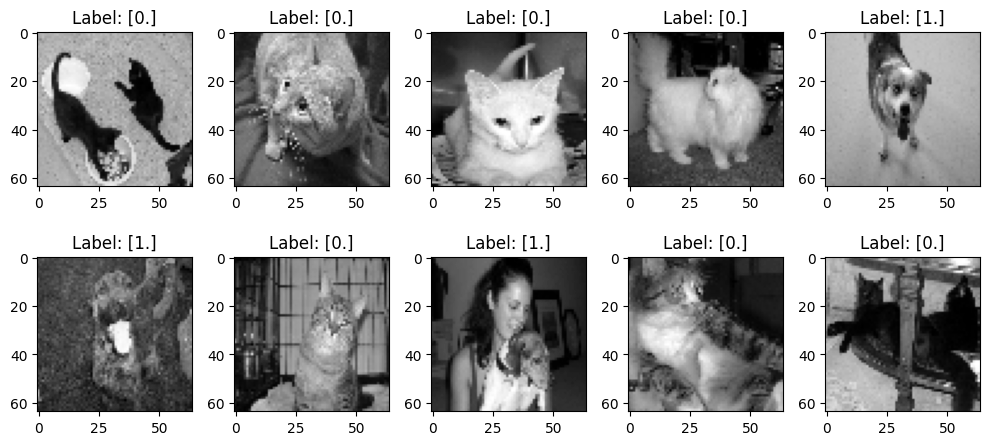

In [41]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.tight_layout()
plt.show()

Une question qui doit vous venir a l'esprit a ce momemt : commet fournir une photo a mon model de neurones artificiels ?

Easy. On considere chaque pixel de la photo comme une variable. la photo est de taille 64x64 pixels. il y a 64x64 = 4096 variables.

En parcouyrant de guahce a droite et de huat en bas les pixels de chaue photo, on a donc le dataset X = (x1, x2, ..., x4096) pour chaue photo.

Ensuite ca ne change pas par rapport au notebook precedent, on appliquer sur X un modele mathematique, et predire si la photo est un chat ou un chien.

Demarche a suivre pour effectuer une telle prediction :
1) Normaliser le dataset. Chaque pixel est code sur 8 bits. 2^8 = 256. il faut normaliser ces valeur entre 0 et 1.
2) Transformer chaque image (64x64 pixels) en une sequence de variable (X = (x1, x2, ..., x4096))
3) Entrainer le modele sur train_set
4) Evaluer le modele sur test_set

# 1

In [42]:
# normalize the data
#X_train = X_train.astype('float32') / 255.0

On veut faire un truc du genre :

In [43]:
X_reshaped = []
for image in X_train:
    image_flat = []
    for row in image:
        for pixel in row:
            image_flat.append(pixel / 255)
    X_reshaped.append(image_flat)

X_reshaped = np.array(X_reshaped)
print(X_reshaped.shape)


(1000, 4096)


On voit bien 2 choses :
1) On a normaliser chaque pixel
2) on a bien un tableau d'entree de 1000 par 4096 dont : chaque ligne represnete une image (1000 images), chaque i-eme colonne les pixels numero i de chacune des 1000 images.

Mais une maniere data science de le faire c'est en appelent directement une fonction pour faire le reshape :

In [44]:
X_train_reshape = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

Pour ceux qui connaissent bien Python :

In [45]:
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(X_train_reshape[0])

(1000, 4096)
(200, 4096)
[164 174 163 ...  87 180  39]


In [46]:
# normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(X_train_reshape[0])


(1000, 4096)
(200, 4096)
[0.6431373  0.68235296 0.6392157  ... 0.34117648 0.7058824  0.15294118]


Maintenant il est temps d'entrainer le modele sur les donnees d'entrainement

In [ ]:
# entrainement du modele :

W, b = artificial_neuron(X_train_reshape, y_train, learning_rate=0.01, num_iter=1000)

TypeError: model() missing 1 required positional argument: 'b'